# Building a Composite Power Index for College Football
## Can Efficiency Metrics Predict Playoff Teams Better Than Raw Rankings?

**Author:** Andrew White 
**Date:** 2026  
**Data:** 2025 FBS college football season (all 136 teams)  
**Season:** 2025–26 (12-team College Football Playoff)

---

### Research Question

Traditional college football rankings rely heavily on win-loss records and subjective voter polls. But do efficiency-based metrics such as points per play, defensive takeaway rates, net scoring margins tell a more predictive story?

This study constructs a **composite Power Index** from six engineered efficiency metrics using z-score standardization and weighted aggregation. We then evaluate whether this index correctly identifies the 2025–26 CFB Playoff teams and compare its rankings against the official CFP selections and raw offensive rankings.

### Why This Matters

The 2025–26 CFP was only the second year of the expanded 12-team format, and it featured significant selection controversy, most notably Notre Dame being left out in favor of conference champions Tulane (American) and James Madison (Sun Belt), and teams like Texas being left out for have an extra loss. An objective, efficiency-based ranking system could help cut through the subjectivity of committee decisions and provide a data-driven alternative.

### Approach

1. **Feature Engineering** — derive per-play and net efficiency metrics from raw team stats  
2. **Index Construction** — standardize and weight metrics into a single Power Index  
3. **Validation** — compare Power Index rankings to actual 2025–26 CFP selections and tournament results  
4. **Win Probability Model** — use the index to estimate game-level outcomes  
5. **Retrospective Analysis** — evaluate whether the index predicted the eventual champion

## 1. Setup & Data Loading

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Plot configuration
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (10, 6)

# Load data
df = pd.read_excel("cfb_combined_data.xlsx")
print(f"Dataset: {df.shape[0]} teams × {df.shape[1]} features")
df.head()

Dataset: 134 teams × 26 features


,School,Games,Off_Rank,Off_PPG,Off_Plays,Off_Total_Yds,Off_Yds_Per_Play,Off_Penalties,Off_Penalty_Yds,Off_Turnovers,...,Def_PenaltyYds,Def_Takeaways,Off_3rdDown_Pct,Def_3rdDown_Pct,Off_redzone_score_pct,Off_redzone_TD_pct,Off_redzone_FG_pct,Def_RZ_Score_%,Deff_RZ_TD_%,Deff_RZ_FG_%
0,Air Force,12,125,18.9,67.6,313.8,4.6,3.2,28.8,1.3,...,48.4,1.0,42.86,37.14,88.89,66.67,22.22,88.89,66.67,22.22
1,Akron,12,120,20.4,63.8,332.8,5.2,6.3,48.7,1.7,...,53.4,0.8,36.20,38.65,78.57,50.00,28.57,88.10,73.81,14.29
2,Alabama,13,22,33.8,64.8,410.2,6.3,7.3,69.1,1.6,...,47.8,2.2,47.27,32.80,85.11,74.47,10.64,78.38,45.95,32.43
3,Appalachian State,11,76,26.6,70.8,426.8,6.0,6.0,56.9,2.0,...,63.8,1.2,43.06,45.60,71.74,54.35,17.39,92.31,66.67,25.64
4,Arizona,12,114,21.8,64.3,354.5,5.5,6.5,57.6,1.7,...,44.5,1.3,42.94,41.45,87.50,62.50,25.00,83.02,67.92,15.09


## 2. Data Quality Check

Before any analysis, we verify data completeness and integrity. Missing values or duplicates could distort efficiency calculations.

In [35]:
# Missing values
missing = df.isna().sum()

# Duplicates
dupes = df.duplicated().sum()
print(f"Duplicate rows: {dupes}")

# Quick sanity checks
print(f"\nTeams: {df['School'].nunique()} unique")
print(f"\nColumn list:")
for col in df.columns:
    print(f"  • {col}")

Duplicate rows: 0

Teams: 134 unique

Column list:
  • School
  • Games
  • Off_Rank
  • Off_PPG
  • Off_Plays
  • Off_Total_Yds
  • Off_Yds_Per_Play
  • Off_Penalties
  • Off_Penalty_Yds
  • Off_Turnovers
  • Def_Rank
  • Def_PPG_Allowed
  • Def_Plays_Faced
  • Def_TotalYds_Allowed
  • Def_YdsPerPlay_Allowed
  • Def_Penalties
  • Def_PenaltyYds
  • Def_Takeaways
  • Off_3rdDown_Pct
  • Def_3rdDown_Pct
  • Off_redzone_score_pct
  • Off_redzone_TD_pct
  • Off_redzone_FG_pct
  • Def_RZ_Score_%
  • Deff_RZ_TD_%
  • Deff_RZ_FG_%


## 3. Exploratory Data Analysis

We focus on four key visualizations that directly inform our index construction. These four are the scoring landscape, offensive vs. defensive balance, efficiency at critical moments, and correlations between raw features.

### 3.1 Scoring Distribution: How Spread Out Are Teams?

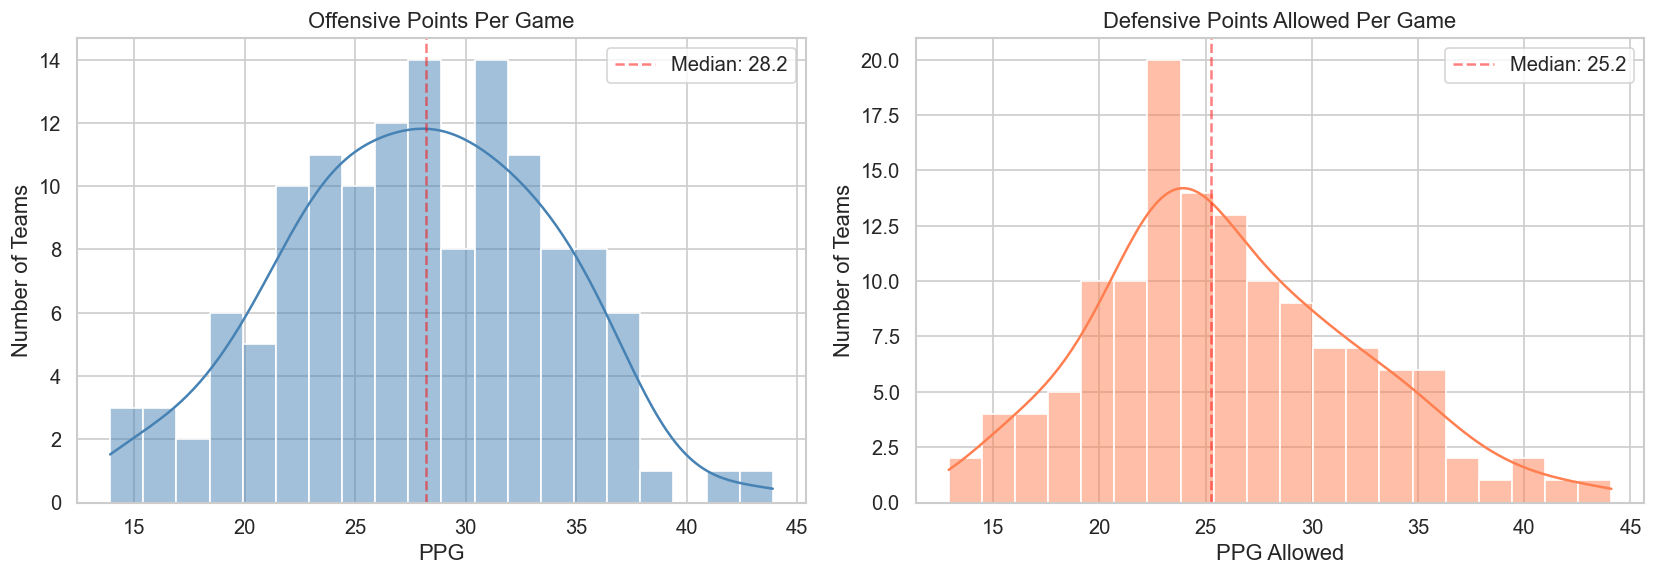

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Offensive PPG
sns.histplot(df["Off_PPG"], bins=20, kde=True, color="steelblue", ax=axes[0])
axes[0].set_title("Offensive Points Per Game")
axes[0].set_xlabel("PPG")
axes[0].set_ylabel("Number of Teams")
axes[0].axvline(df["Off_PPG"].median(), ls="--", color="red", alpha=0.5, label=f'Median: {df["Off_PPG"].median():.1f}')
axes[0].legend()

# Defensive PPG Allowed
sns.histplot(df["Def_PPG_Allowed"], bins=20, kde=True, color="coral", ax=axes[1])
axes[1].set_title("Defensive Points Allowed Per Game")
axes[1].set_xlabel("PPG Allowed")
axes[1].set_ylabel("Number of Teams")
axes[1].axvline(df["Def_PPG_Allowed"].median(), ls="--", color="red", alpha=0.5, label=f'Median: {df["Def_PPG_Allowed"].median():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

Both distributions are roughly normal. The offensive distribution shows a wider spread, suggesting more variance in scoring ability than in defensive performance. This is consistent with the idea that elite offenses are rarer than competent defenses.

### 3.2 Offense vs. Defense: Where Do Teams Live?

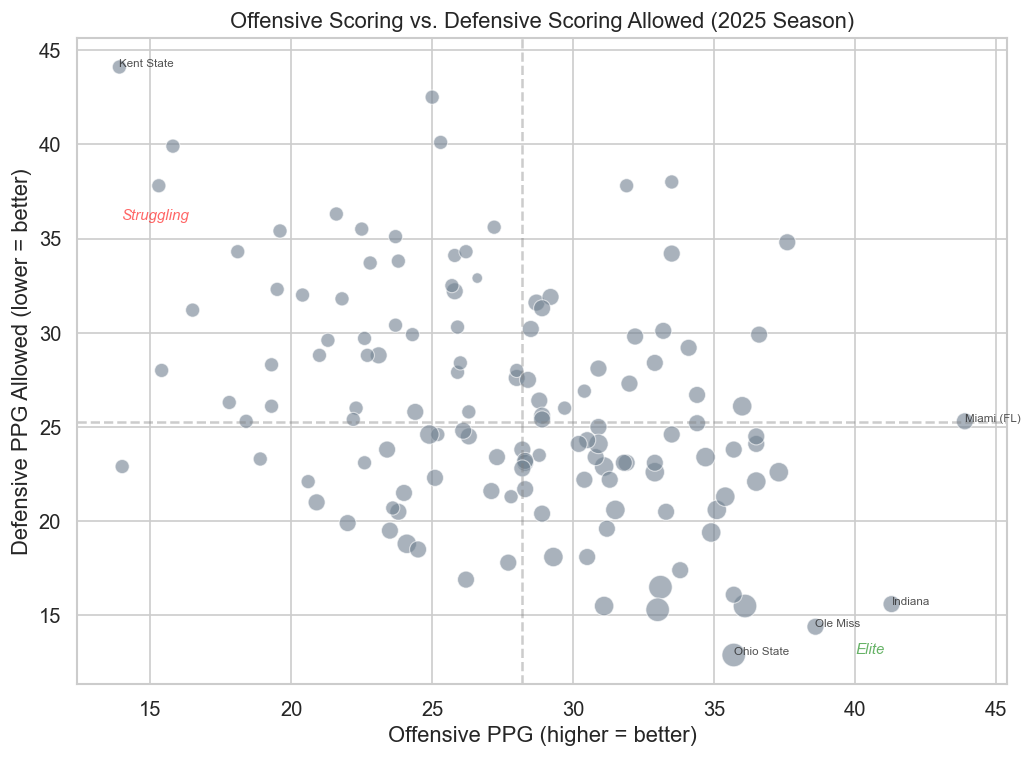

In [37]:
plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    data=df, x="Off_PPG", y="Def_PPG_Allowed",
    size="Games", sizes=(40, 200), alpha=0.6, color="slategray", legend=False
)

# Annotate notable teams (extreme performers)
for _, row in df.iterrows():
    if row["Off_PPG"] > 38 or row["Def_PPG_Allowed"] < 14 or row["Off_PPG"] < 14:
        plt.annotate(row["School"], (row["Off_PPG"], row["Def_PPG_Allowed"]),
                     fontsize=7, alpha=0.8)

# Quadrant lines at medians
plt.axvline(df["Off_PPG"].median(), ls="--", color="gray", alpha=0.4)
plt.axhline(df["Def_PPG_Allowed"].median(), ls="--", color="gray", alpha=0.4)

plt.xlabel("Offensive PPG (higher = better)")
plt.ylabel("Defensive PPG Allowed (lower = better)")
plt.title("Offensive Scoring vs. Defensive Scoring Allowed (2025 Season)")
plt.text(40, 13, "Elite", fontsize=9, fontstyle="italic", color="green", alpha=0.6)
plt.text(14, 36, "Struggling", fontsize=9, fontstyle="italic", color="red", alpha=0.6)
plt.show()

Teams in the **lower-right quadrant** (high offense, low points allowed) are the elite programs. This plot motivates the need for a composite metric that captures *both* sides of the ball, not just raw scoring.

### 3.3 Third-Down Conversion: The Hidden Efficiency Metric

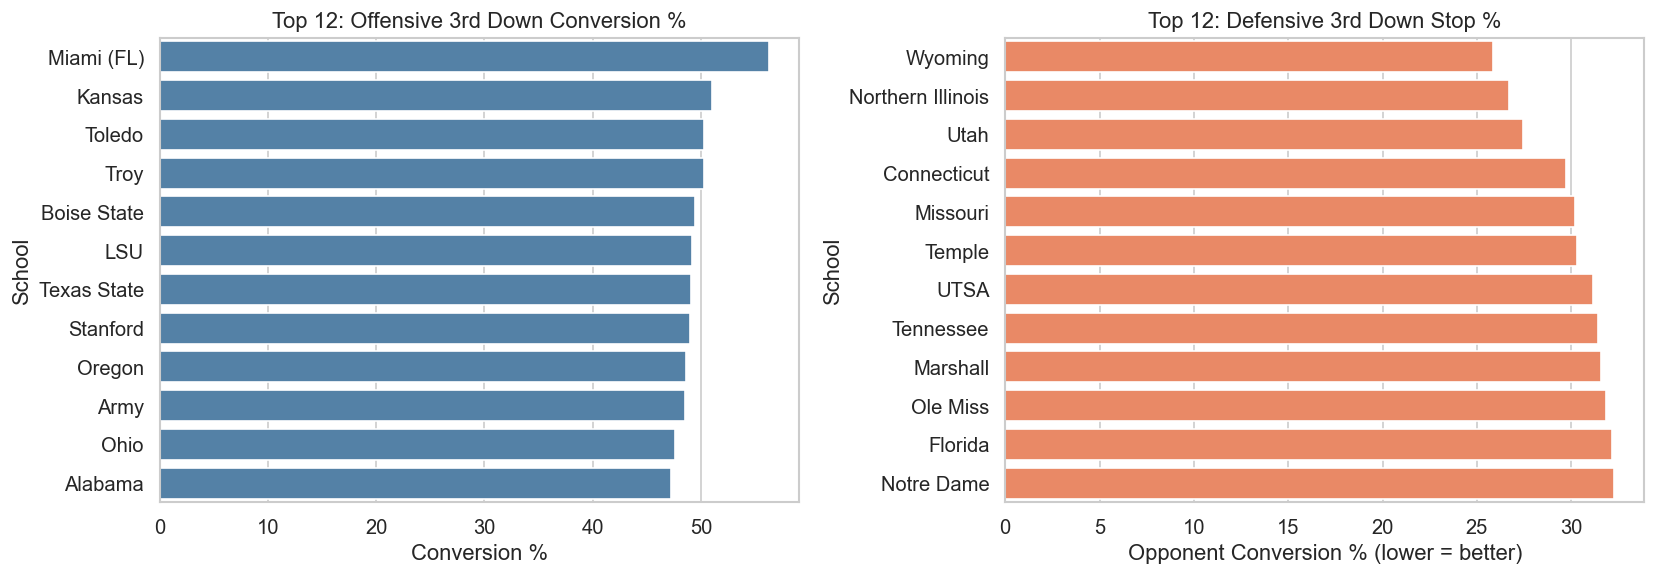

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Offensive 3rd down
top_off_3rd = df.sort_values("Off_3rdDown_Pct", ascending=False).head(12)
sns.barplot(y="School", x="Off_3rdDown_Pct", data=top_off_3rd, color="steelblue", ax=axes[0])
axes[0].set_title("Top 12: Offensive 3rd Down Conversion %")
axes[0].set_xlabel("Conversion %")

# Defensive 3rd down (lower = better)
top_def_3rd = df.sort_values("Def_3rdDown_Pct", ascending=True).head(12)
sns.barplot(y="School", x="Def_3rdDown_Pct", data=top_def_3rd, color="coral", ax=axes[1])
axes[1].set_title("Top 12: Defensive 3rd Down Stop %")
axes[1].set_xlabel("Opponent Conversion % (lower = better)")

plt.tight_layout()
plt.show()

### 3.4 Feature Correlations: What Drives Winning?

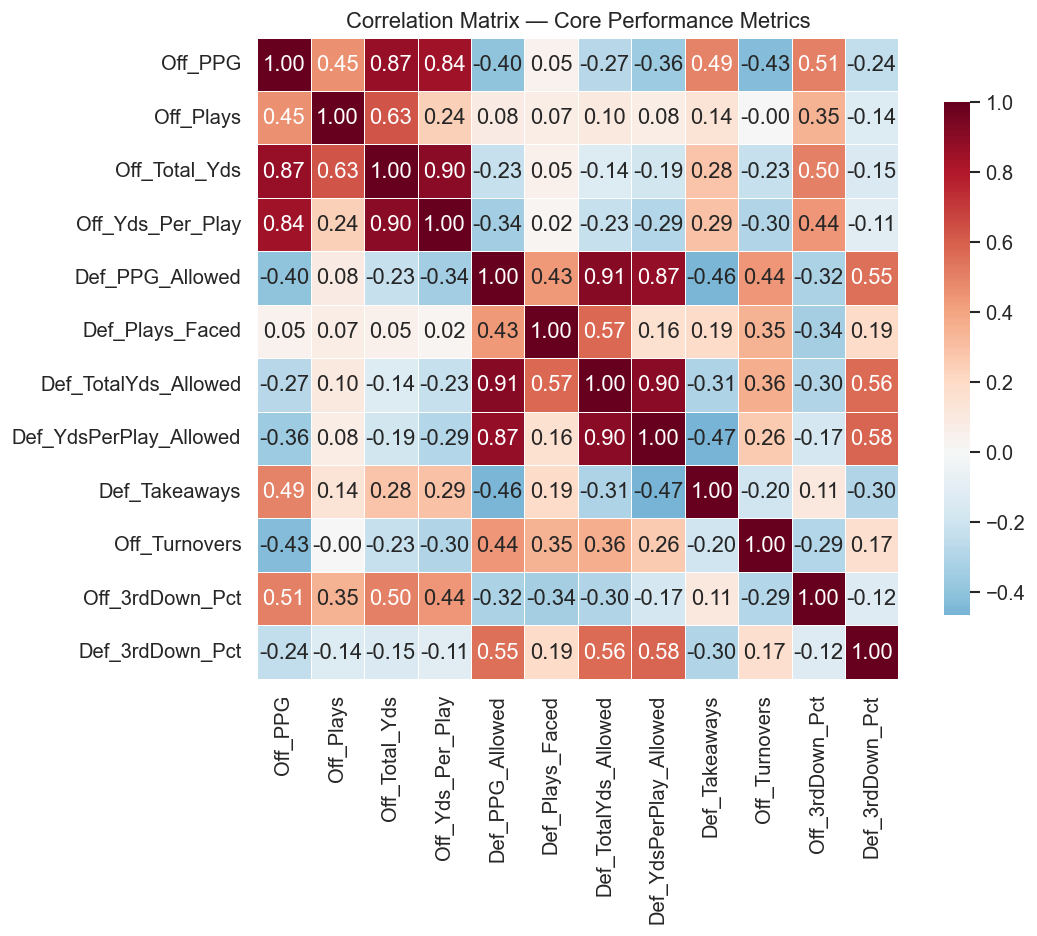

In [39]:
# Select the core raw metrics we'll use for engineering
core_cols = [
    "Off_PPG", "Off_Plays", "Off_Total_Yds", "Off_Yds_Per_Play",
    "Def_PPG_Allowed", "Def_Plays_Faced", "Def_TotalYds_Allowed",
    "Def_YdsPerPlay_Allowed", "Def_Takeaways", "Off_Turnovers",
    "Off_3rdDown_Pct", "Def_3rdDown_Pct"
]

plt.figure(figsize=(10, 8))
sns.heatmap(
    df[core_cols].corr(), annot=True, fmt=".2f",
    cmap="RdBu_r", center=0, square=True, linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix — Core Performance Metrics")
plt.tight_layout()
plt.show()

Key takeaway: Offensive PPG correlates strongly with yards per play and total yards, but weakly with defensive metrics. This confirms that offense and defense capture **independent dimensions** of team quality and that both are needed in a composite index.

## 4. Feature Engineering

Raw totals are misleading because teams play different numbers of games (12–16). We derive six **per-play and net efficiency metrics** that normalize for opportunity and capture both sides of the ball.

| Metric | Formula | What It Captures |
|---|---|---|
| **Offensive Efficiency** | PPG ÷ Plays/Game | Points generated per offensive snap |
| **Explosive Score** | Yds/Play × Off Efficiency | Big-play capability weighted by scoring |
| **Defensive Efficiency** | PPG Allowed ÷ Plays Faced/Game | Points surrendered per defensive snap |
| **Defensive Havoc Rate** | Takeaways ÷ Plays Faced/Game | Ability to create turnovers per snap |
| **Net PPG** | Off PPG − Def PPG Allowed | Overall scoring margin |
| **Net Yards/Game** | Off Yds − Def Yds Allowed | Overall yardage margin |

In [40]:
# Engineer efficiency features
df["Off_Efficiency"] = df["Off_PPG"] / df["Off_Plays"]
df["Def_Efficiency"] = df["Def_PPG_Allowed"] / df["Def_Plays_Faced"]
df["Explosive_Score"] = df["Off_Yds_Per_Play"] * df["Off_Efficiency"]
df["Def_Havoc_Rate"] = df["Def_Takeaways"] / df["Def_Plays_Faced"]
df["Net_PPG"] = df["Off_PPG"] - df["Def_PPG_Allowed"]
df["Net_Yds_Per_Game"] = df["Off_Total_Yds"] - df["Def_TotalYds_Allowed"]

# Preview the engineered features
engineered = ["School", "Off_Efficiency", "Explosive_Score", "Def_Efficiency",
              "Def_Havoc_Rate", "Net_PPG", "Net_Yds_Per_Game"]
df[engineered].sort_values("Net_PPG", ascending=False).head(10)

,School,Off_Efficiency,Explosive_Score,Def_Efficiency,Def_Havoc_Rate,Net_PPG,Net_Yds_Per_Game
41,Indiana,0.630534,4.098473,0.260870,0.030100,25.7,169.2
85,Ole Miss,0.537604,3.924513,0.207194,0.025899,24.2,215.3
81,Ohio State,0.577670,3.985922,0.212171,0.019737,22.8,174.8
79,Notre Dame,0.570300,3.592891,0.239567,0.032457,20.6,91.7
105,Tennessee,0.484396,2.954817,0.250389,0.024883,19.6,153.8
61,Miami (FL),0.619182,4.705783,0.407407,0.022544,18.6,210.0
106,Texas,0.468750,2.906250,0.237578,0.029503,17.7,154.1
88,Penn State,0.503040,3.269757,0.261490,0.025357,16.6,135.4
2,Alabama,0.521605,3.286111,0.256637,0.032448,16.4,90.1
8,Army,0.491311,2.947867,0.277281,0.025045,15.6,83.2


### 4.1 Engineered Feature Distributions

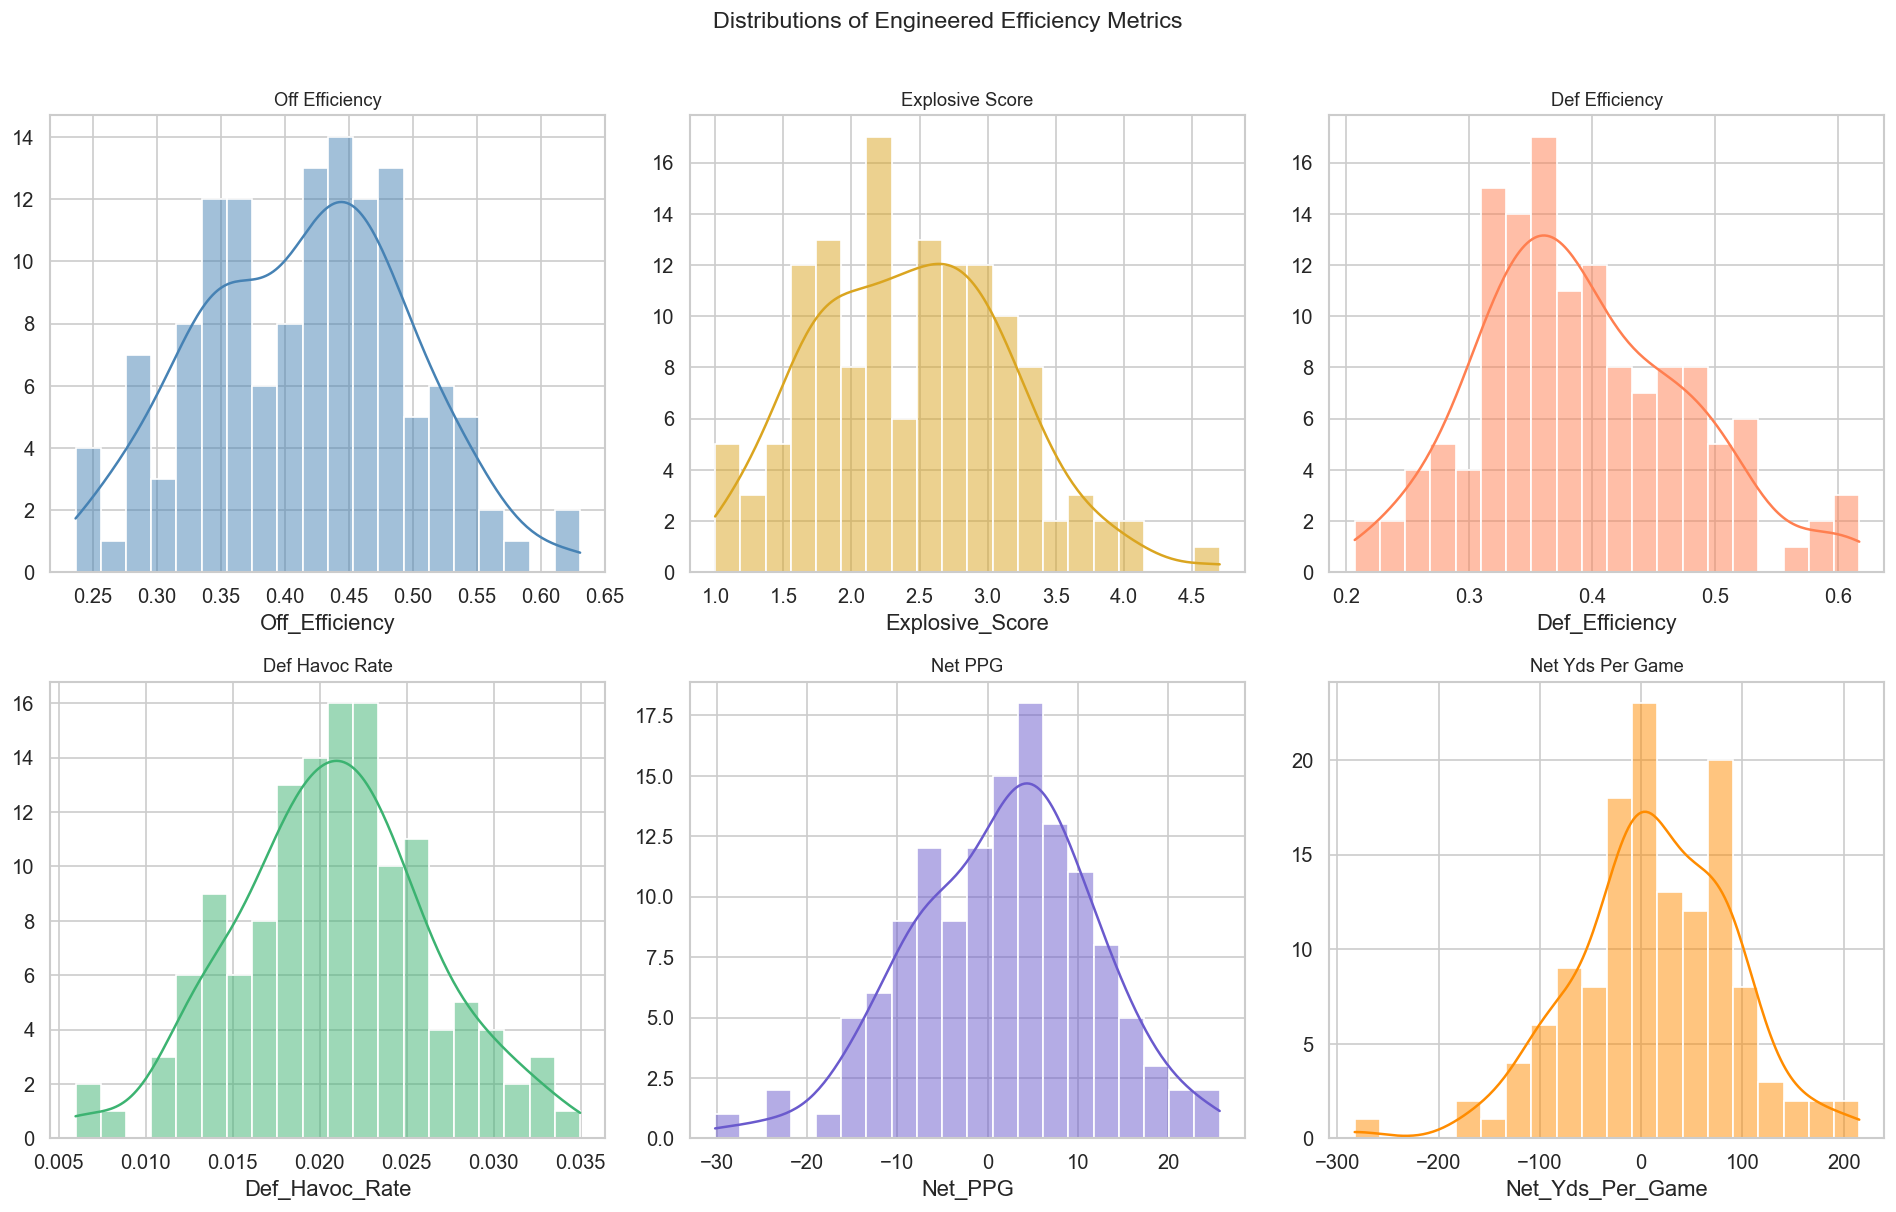

In [41]:
metrics = ["Off_Efficiency", "Explosive_Score", "Def_Efficiency",
           "Def_Havoc_Rate", "Net_PPG", "Net_Yds_Per_Game"]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
colors = ["steelblue", "goldenrod", "coral", "mediumseagreen", "slateblue", "darkorange"]

for ax, col, color in zip(axes.flat, metrics, colors):
    sns.histplot(df[col], bins=20, kde=True, color=color, ax=ax)
    ax.set_title(col.replace("_", " "), fontsize=11)
    ax.set_ylabel("")

plt.suptitle("Distributions of Engineered Efficiency Metrics", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### 4.2 How Do Engineered Metrics Relate to Each Other?

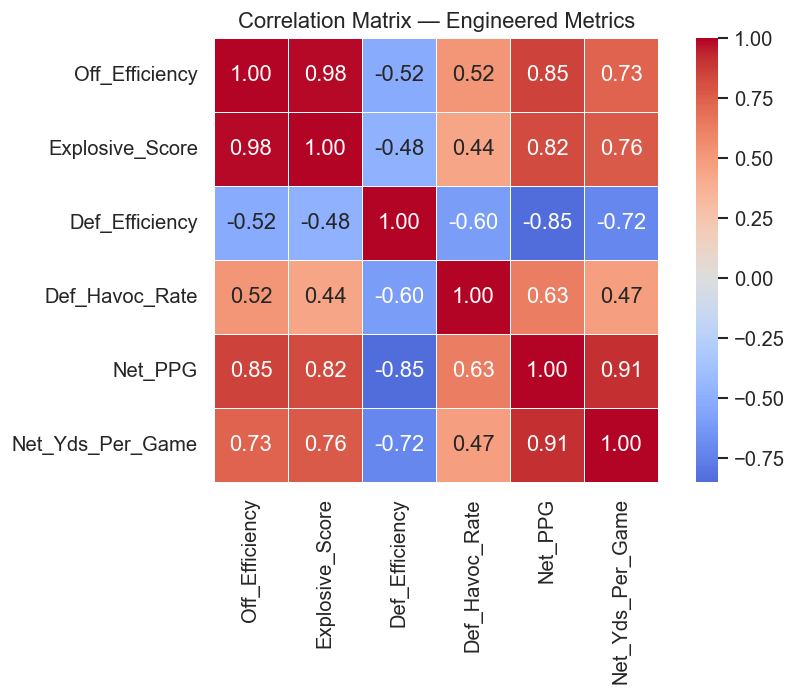

In [55]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[metrics].corr(), annot=True, fmt=".2f",cmap="coolwarm", center=0, square=True, linewidths=0.5)
plt.title("Correlation Matrix — Engineered Metrics")
plt.tight_layout()
plt.show()

Net PPG and Net Yards/Game are highly correlated (as expected, scoring and yardage margins move together). To avoid double-counting, we assign them lower combined weight in the index. Offensive Efficiency and Explosive Score also share variance, but capture meaningfully different aspects of offensive quality.

## 5. Power Index Construction

### Methodology

We standardize each metric to z-scores (mean=0, std=1) so that all features contribute on a common scale, then combine them with hand-tuned weights reflecting football domain knowledge:

| Component | Weight | Rationale |
|---|---|---|
| Offensive Efficiency | +0.30 | Scoring per snap is the strongest predictor of wins |
| Explosive Score | +0.20 | Big-play ability separates good from great offenses |
| Defensive Efficiency | −0.25 | Lower is better; flipped via negative weight |
| Defensive Havoc Rate | +0.10 | Turnovers created are high-leverage events |
| Net PPG | +0.10 | Overall scoring margin as a sanity check |
| Net Yards/Game | +0.05 | Secondary margin metric, low weight to avoid redundancy |

**Note:** Weights sum to 1.0 (in absolute value terms). The negative weight on Defensive Efficiency means teams that allow fewer points per play score higher.

In [43]:
# Standardize features
scaler = StandardScaler()
z_cols = [m + "_z" for m in metrics]
df[z_cols] = scaler.fit_transform(df[metrics])

# Construct the Power Index
weights = {
    "Off_Efficiency_z":   0.30,
    "Explosive_Score_z":  0.20,
    "Def_Efficiency_z":  -0.25,   # negative: lower defensive PPG/play = better
    "Def_Havoc_Rate_z":   0.10,
    "Net_PPG_z":          0.10,
    "Net_Yds_Per_Game_z": 0.05,
}

df["Power_Index"] = sum(df[col] * w for col, w in weights.items())
df["Power_Rank"] = df["Power_Index"].rank(ascending=False).astype(int)

# Display top 25
top25 = df[["School", "Power_Index", "Power_Rank"] + metrics].sort_values("Power_Rank").head(25)
top25.style.format({"Power_Index": "{:.3f}"}).hide(axis="index")

School,Power_Index,Power_Rank,Off_Efficiency,Explosive_Score,Def_Efficiency,Def_Havoc_Rate,Net_PPG,Net_Yds_Per_Game
Indiana,2.151,1,0.630534,4.098473,0.260870,0.030100,25.700000,169.200000
Ole Miss,1.858,2,0.537604,3.924513,0.207194,0.025899,24.200000,215.300000
Ohio State,1.857,3,0.577670,3.985922,0.212171,0.019737,22.800000,174.800000
Notre Dame,1.793,4,0.570300,3.592891,0.239567,0.032457,20.600000,91.700000
Miami (FL),1.668,5,0.619182,4.705783,0.407407,0.022544,18.600000,210.000000
Alabama,1.435,6,0.521605,3.286111,0.256637,0.032448,16.400000,90.100000
Penn State,1.251,7,0.503040,3.269757,0.261490,0.025357,16.600000,135.400000
Tulane,1.209,8,0.548438,3.455156,0.335505,0.026059,14.500000,81.500000
Texas,1.190,9,0.468750,2.906250,0.237578,0.029503,17.700000,154.100000
Tennessee,1.159,10,0.484396,2.954817,0.250389,0.024883,19.600000,153.800000


### 5.1 Power Index Distribution

/var/folders/qk/vdr0dvt91yj5p8tdhjkrzflh0000gn/T/ipykernel_6665/1909780405.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="School", x="Power_Index", data=top15, palette="viridis", ax=axes[1])


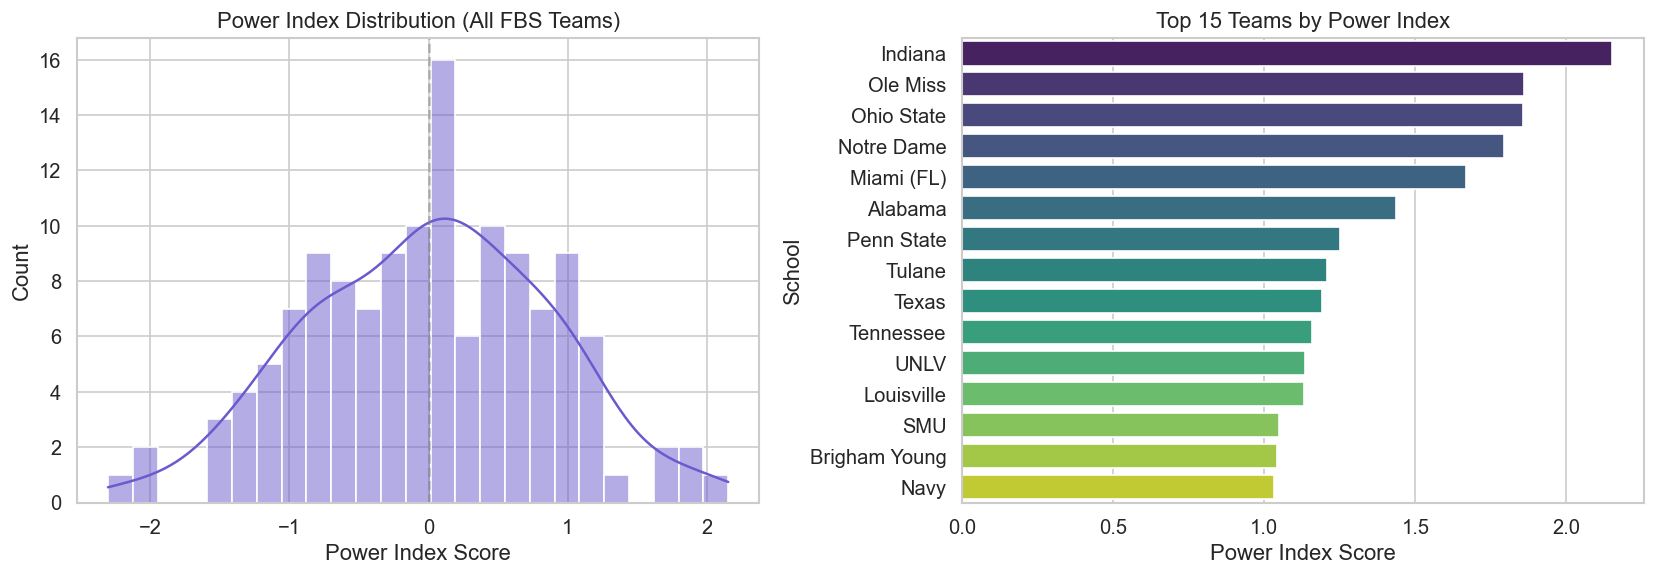

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
sns.histplot(df["Power_Index"], bins=25, kde=True, color="slateblue", ax=axes[0])
axes[0].axvline(0, ls="--", color="gray", alpha=0.5)
axes[0].set_title("Power Index Distribution (All FBS Teams)")
axes[0].set_xlabel("Power Index Score")

# Top 15 bar chart
top15 = df.sort_values("Power_Rank").head(15)
sns.barplot(y="School", x="Power_Index", data=top15, palette="viridis", ax=axes[1])
axes[1].set_title("Top 15 Teams by Power Index")
axes[1].set_xlabel("Power Index Score")

plt.tight_layout()
plt.show()

### 5.2 Power Index vs. Scoring Margin

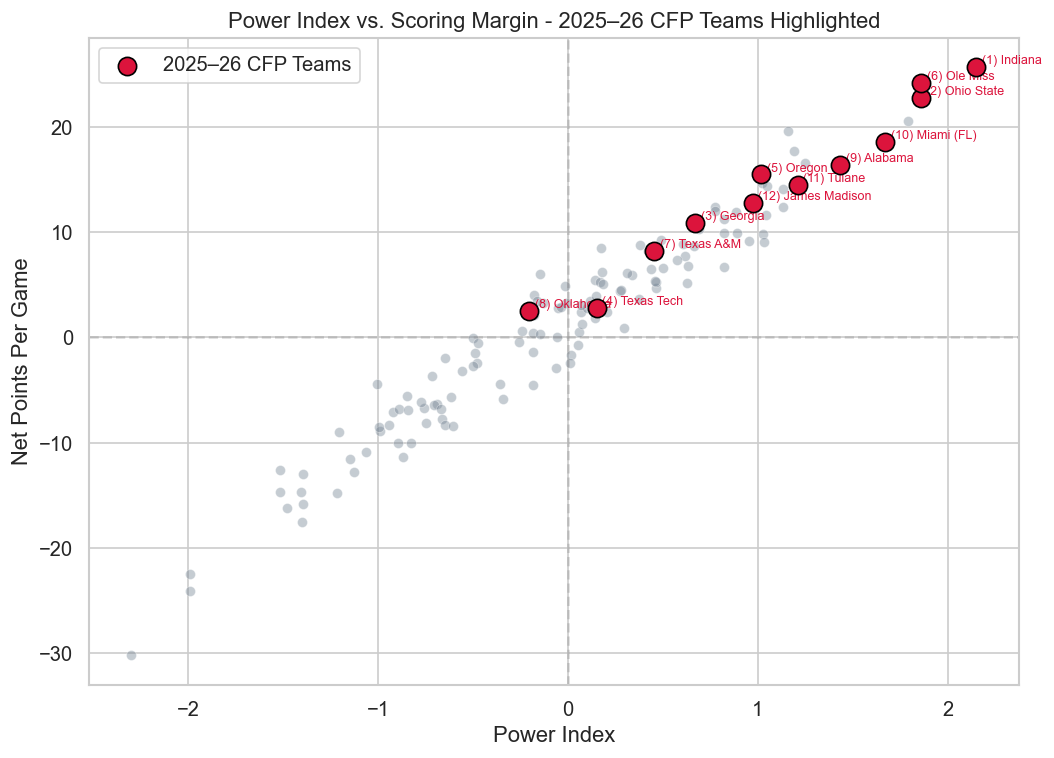

In [56]:
# ══════════════════════════════════════════════════════════════
# 2025–26 CFP Teams (12-team bracket, second year of expanded format)
# ══════════════════════════════════════════════════════════════

cfp_teams = [
    "Indiana", "Ohio State", "Georgia", "Texas Tech",
    "Oregon", "Ole Miss", "Texas A&M", "Oklahoma",
    "Alabama", "Miami (FL)", "Tulane", "James Madison"
]

cfp_seeds = {
    "Indiana": 1, "Ohio State": 2, "Georgia": 3, "Texas Tech": 4,
    "Oregon": 5, "Ole Miss": 6, "Texas A&M": 7, "Oklahoma": 8,
    "Alabama": 9, "Miami (FL)": 10, "Tulane": 11, "James Madison": 12
}

df["Made_CFP"] = df["School"].isin(cfp_teams).astype(int)

# Scatter: Power Index vs Net PPG with CFP teams highlighted
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x="Power_Index", y="Net_PPG", alpha=0.4, color="slategray")

cfp_data = df[df["Made_CFP"] == 1]
plt.scatter(cfp_data["Power_Index"], cfp_data["Net_PPG"],
            color="crimson", s=120, zorder=5, edgecolors="black", label="2025–26 CFP Teams")

for _, row in cfp_data.iterrows():
    seed = cfp_seeds.get(row["School"], "")
    label = f"({seed}) {row['School']}"
    plt.annotate(label, (row["Power_Index"] + 0.03, row["Net_PPG"] + 0.3),
                 fontsize=7.5, color="crimson")

plt.axvline(0, ls="--", color="gray", alpha=0.3)
plt.axhline(0, ls="--", color="gray", alpha=0.3)
plt.xlabel("Power Index")
plt.ylabel("Net Points Per Game")
plt.title("Power Index vs. Scoring Margin - 2025–26 CFP Teams Highlighted")
plt.legend()
plt.show()

## 6. Validation: Does the Power Index Predict Playoff Teams?

The real test: how well does our index identify teams that *actually* made the 2025–26 College Football Playoff?

The 2025–26 CFP was notable for several reasons:
- **Indiana** went undefeated and won the national championship, defeating Miami (FL) in the title game
- **Five SEC teams** were selected (Georgia, Ole Miss, Texas A&M, Oklahoma, Alabama)
- **Two Group of 5 teams** earned automatic bids as conference champions (Tulane, James Madison)
- **Notre Dame was controversially left out** despite being ranked ahead of Miami in every CFP poll except the final one

We compare three ranking systems:
1. **Our Power Index** — efficiency-based composite  
2. **Official CFP Selections** — committee picks  
3. **Raw Offensive Rank** — simple points-per-game ordering

In [57]:
# ══════════════════════════════════════════════════════════════
# How many of the 12 CFP teams does our index capture in the top 12?
# ══════════════════════════════════════════════════════════════

our_top12 = set(df.sort_values("Power_Rank").head(12)["School"])
actual_cfp = set(cfp_teams)

overlap = our_top12.intersection(actual_cfp)
missed = actual_cfp - our_top12
false_pos = our_top12 - actual_cfp

print("=" * 55)
print("  POWER INDEX vs. ACTUAL 2025–26 CFP SELECTIONS")
print("=" * 55)
print(f"\n  CFP teams captured in our Top 12: {len(overlap)} / 12")
print(f"\n Correctly identified:")
for t in sorted(overlap):
    seed = cfp_seeds.get(t, "")
    print(f"     ({seed}) {t}")
print(f"\n Missed (in CFP but not in our Top 12):")
for t in sorted(missed):
    seed = cfp_seeds.get(t, "")
    rank = df.loc[df["School"] == t, "Power_Rank"].values
    r = rank[0] if len(rank) > 0 else "N/A"
    print(f"     ({seed}) {t} — our rank: #{r}")
print(f"\n In our Top 12 but not in CFP:")
for t in sorted(false_pos):
    rank = df.loc[df["School"] == t, "Power_Rank"].values
    r = rank[0] if len(rank) > 0 else "N/A"
    print(f"     {t} — our rank: #{r}")

# Compare: how many CFP teams does raw Off_Rank top-12 capture?
raw_top12 = set(df.sort_values("Off_Rank").head(12)["School"])
raw_overlap = raw_top12.intersection(actual_cfp)
print(f"\n{'=' * 55}")
print(f"  Raw Offensive Rank captures: {len(raw_overlap)} / 12 CFP teams")
print(f"  Power Index captures:        {len(overlap)} / 12 CFP teams")
print(f"{'=' * 55}")

  POWER INDEX vs. ACTUAL 2025–26 CFP SELECTIONS

  CFP teams captured in our Top 12: 6 / 12

 Correctly identified:
     (9) Alabama
     (1) Indiana
     (10) Miami (FL)
     (2) Ohio State
     (6) Ole Miss
     (11) Tulane

 Missed (in CFP but not in our Top 12):
     (3) Georgia — our rank: #31
     (12) James Madison — our rank: #20
     (8) Oklahoma — our rank: #86
     (5) Oregon — our rank: #19
     (7) Texas A&M — our rank: #43
     (4) Texas Tech — our rank: #58

 In our Top 12 but not in CFP:
     Louisville — our rank: #12
     Notre Dame — our rank: #4
     Penn State — our rank: #7
     Tennessee — our rank: #10
     Texas — our rank: #9
     UNLV — our rank: #11

  Raw Offensive Rank captures: 4 / 12 CFP teams
  Power Index captures:        6 / 12 CFP teams


In [58]:
# ══════════════════════════════════════════════════════════════
# Detailed comparison: Where do CFP teams rank in our index?
# ══════════════════════════════════════════════════════════════

cfp_comparison = (df[df["Made_CFP"] == 1][["School", "Power_Rank", "Off_Rank", "Power_Index", "Net_PPG"]].sort_values("Power_Rank").copy())

cfp_comparison["CFP_Seed"] = cfp_comparison["School"].map(cfp_seeds)
cfp_comparison["Rank_vs_Seed_Diff"] = cfp_comparison["CFP_Seed"] - cfp_comparison["Power_Rank"]
cfp_comparison = cfp_comparison[["School", "CFP_Seed", "Power_Rank", "Off_Rank", "Power_Index", "Net_PPG", "Rank_vs_Seed_Diff"]]

print("Positive Rank_vs_Seed_Diff = our index ranks them HIGHER than the committee did")
print("Negative Rank_vs_Seed_Diff = our index ranks them LOWER than the committee did\n")
cfp_comparison

Positive Rank_vs_Seed_Diff = our index ranks them HIGHER than the committee did
Negative Rank_vs_Seed_Diff = our index ranks them LOWER than the committee did



,School,CFP_Seed,Power_Rank,Off_Rank,Power_Index,Net_PPG,Rank_vs_Seed_Diff
41,Indiana,1,1,2,2.150995,25.7,0
85,Ole Miss,6,2,3,1.858336,24.2,4
81,Ohio State,2,3,13,1.856988,22.8,-1
61,Miami (FL),10,5,1,1.668497,18.6,5
2,Alabama,9,6,22,1.434607,16.4,3
112,Tulane,11,8,16,1.208763,14.5,3
86,Oregon,5,19,17,1.016113,15.5,-14
45,James Madison,12,20,26,0.972004,12.8,-8
34,Georgia,3,31,38,0.668682,10.9,-28
107,Texas A&M,7,43,49,0.454838,8.2,-36


### 6.1 Visual Comparison: Power Index Rank vs. CFP Seed

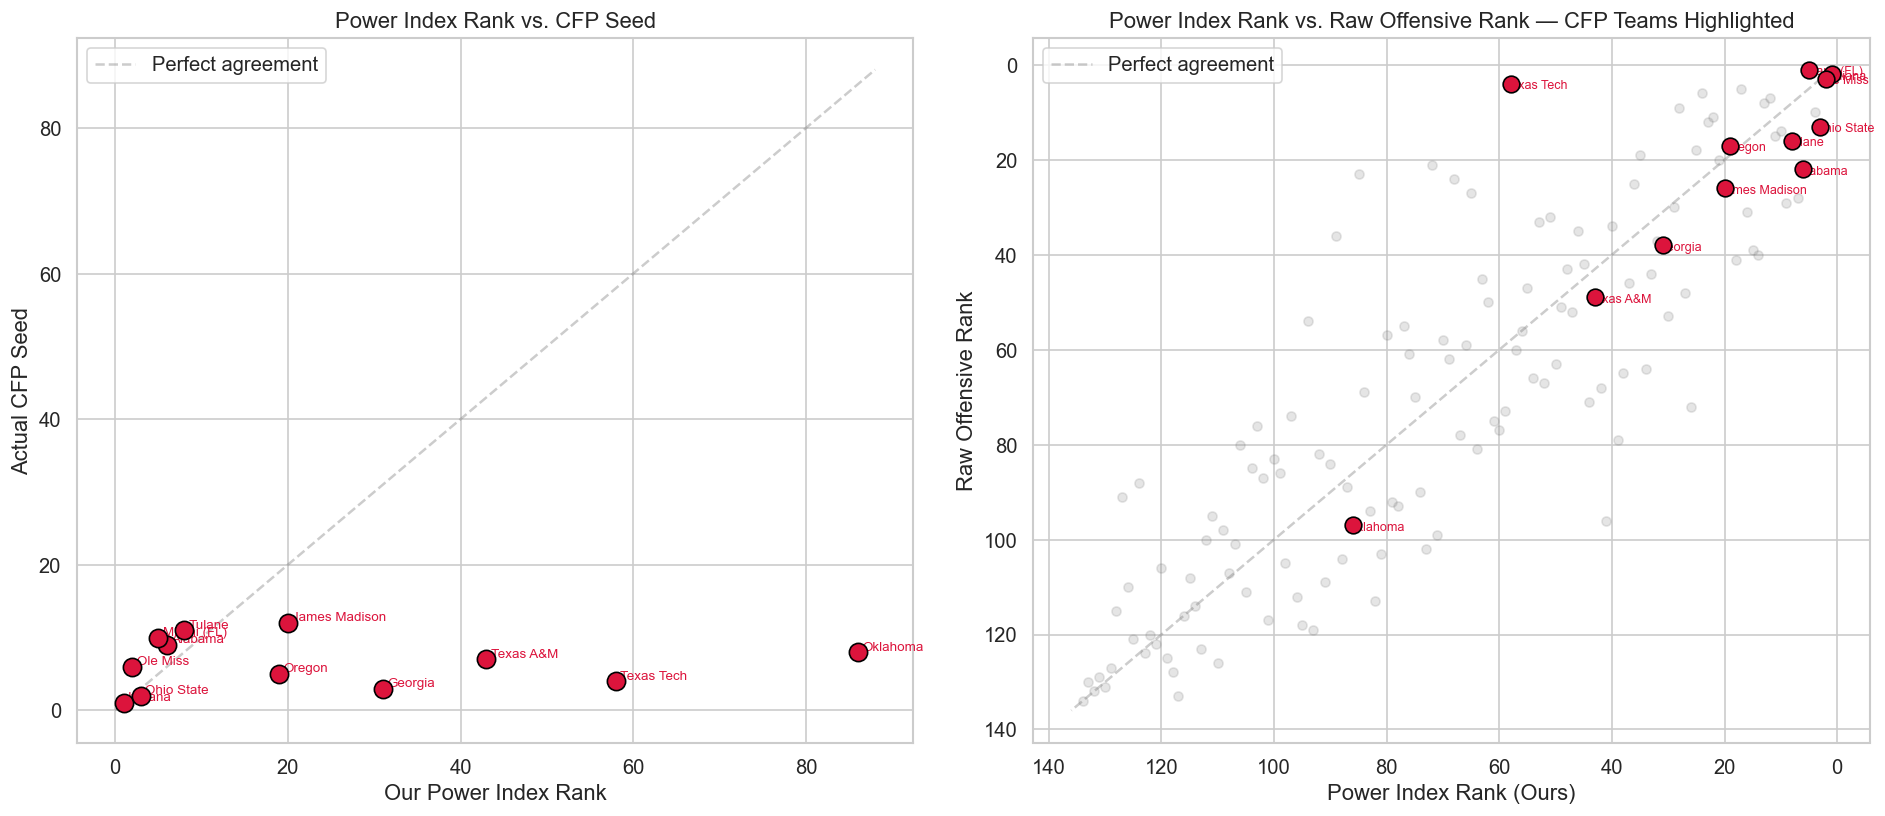

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Power Index Rank vs CFP Seed ─
ax = axes[0]
cfp_df = df[df["Made_CFP"] == 1].copy()
cfp_df["CFP_Seed"] = cfp_df["School"].map(cfp_seeds)

ax.scatter(cfp_df["Power_Rank"], cfp_df["CFP_Seed"],
           color="crimson", s=120, edgecolors="black", zorder=5)

for _, row in cfp_df.iterrows():
    ax.annotate(row["School"], (row["Power_Rank"] + 0.5, row["CFP_Seed"] + 0.3),
                fontsize=8, color="crimson")

# Perfect agreement line
ax.plot([0, max(cfp_df["Power_Rank"].max(), 12) + 2],
        [0, max(cfp_df["Power_Rank"].max(), 12) + 2],
        ls="--", color="gray", alpha=0.4, label="Perfect agreement")

ax.set_xlabel("Our Power Index Rank")
ax.set_ylabel("Actual CFP Seed")
ax.set_title("Power Index Rank vs. CFP Seed")
ax.legend()

# Power Index Rank vs Raw Offensive Rank ─
ax = axes[1]

# All teams as background
ax.scatter(df["Power_Rank"], df["Off_Rank"], alpha=0.2, color="gray", s=30)

# CFP teams highlighted
ax.scatter(cfp_df["Power_Rank"], cfp_df["Off_Rank"],
           color="crimson", s=100, edgecolors="black", zorder=5)

for _, row in cfp_df.iterrows():
    ax.annotate(row["School"], (row["Power_Rank"] + 1, row["Off_Rank"] + 1),
                fontsize=7.5, color="crimson")

ax.plot([1, 136], [1, 136], ls="--", color="gray", alpha=0.4, label="Perfect agreement")

ax.set_xlabel("Power Index Rank (Ours)")
ax.set_ylabel("Raw Offensive Rank")
ax.set_title("Power Index Rank vs. Raw Offensive Rank — CFP Teams Highlighted")
ax.legend()
ax.invert_xaxis()
ax.invert_yaxis()

plt.tight_layout()
plt.show()

In the left plot, points **near the diagonal** indicate agreement between our index and the committee. Points **below** the line are teams the committee seeded higher than our index would. 

In the right plot, points **above** the diagonal are teams our index ranks higher than raw offense alone — these are teams with strong defenses that raw offensive rank ignores.

### 6.2 Championship Retrospective: Did the Index See Indiana Coming?

Indiana went undefeated in 2025, won the Big Ten Championship, and defeated Miami (FL) in the national title game. Let's see how our index rated the champion and the runner-up heading into the playoff.

🏆 2025–26 CFP National Championship Matchup
   Indiana vs. Miami (FL)
   Result: Indiana wins the national championship



,School,Power_Rank,Power_Index,Off_Efficiency,Explosive_Score,Def_Efficiency,Def_Havoc_Rate,Net_PPG,Net_Yds_Per_Game
41,Indiana,1,2.150995,0.630534,4.098473,0.260870,0.030100,25.7,169.2
61,Miami (FL),5,1.668497,0.619182,4.705783,0.407407,0.022544,18.6,210.0


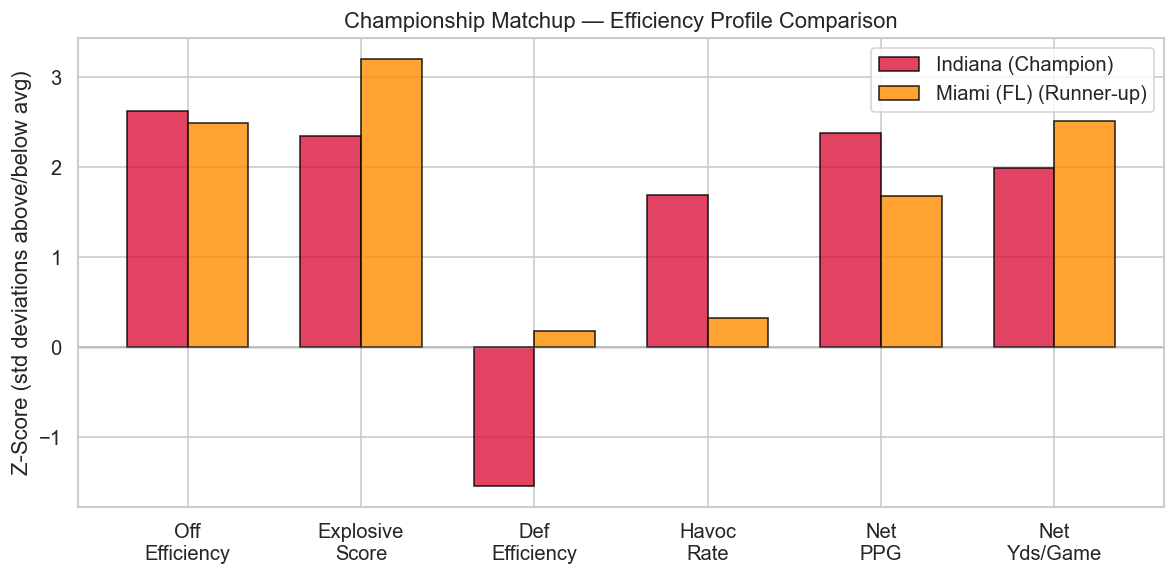

In [49]:
# Championship game teams
champ_teams = ["Indiana", "Miami (FL)"]
champ_df = df[df["School"].isin(champ_teams)][
    ["School", "Power_Rank", "Power_Index"] + metrics
].sort_values("Power_Rank")

print("🏆 2025–26 CFP National Championship Matchup")
print("   Indiana vs. Miami (FL)")
print(f"   Result: Indiana wins the national championship\n")
display(champ_df)

# Radar-style comparison (bar chart version)
fig, ax = plt.subplots(figsize=(10, 5))

metric_labels = ["Off\nEfficiency", "Explosive\nScore", "Def\nEfficiency", "Havoc\nRate", "Net\nPPG", "Net\nYds/Game"]
x = np.arange(len(metrics))
width = 0.35

indiana_vals = df[df["School"] == "Indiana"][metrics].values.flatten()
miami_vals = df[df["School"] == "Miami (FL)"][metrics].values.flatten()

# Normalize to z-scores for comparison
indiana_z = df[df["School"] == "Indiana"][z_cols].values.flatten()
miami_z = df[df["School"] == "Miami (FL)"][z_cols].values.flatten()

bars1 = ax.bar(x - width/2, indiana_z, width, label="Indiana (Champion)", color="crimson", edgecolor="black", alpha=0.8)
bars2 = ax.bar(x + width/2, miami_z, width, label="Miami (FL) (Runner-up)", color="darkorange", edgecolor="black", alpha=0.8)

ax.set_ylabel("Z-Score (std deviations above/below avg)")
ax.set_title("Championship Matchup — Efficiency Profile Comparison")
ax.set_xticks(x)
ax.set_xticklabels(metric_labels)
ax.legend()
ax.axhline(0, ls="-", color="gray", alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Application: Win Probability Model

As a practical application, we use the Power Index to estimate head-to-head win probabilities via a logistic function:

$$P(A \text{ beats } B) = \frac{1}{1 + e^{-k \cdot (\text{PI}_A - \text{PI}_B + \text{HFA})}}$$

Where:
- **PI** = Power Index score  
- **HFA** = Home Field Advantage adjustment (0.4 standard deviations)  
- **k** = Scaling constant (1.2) controlling how decisive index gaps are

In [60]:
def win_probability(team_a, team_b, hfa=0.0, k=1.2):
    """Estimate win probability for team_a over team_b using Power Index.
    Set hfa=0.4 for home advantage, 0.0 for neutral site."""
    pi_a = df.loc[df["School"] == team_a, "Power_Index"].values[0]
    pi_b = df.loc[df["School"] == team_b, "Power_Index"].values[0]
    diff = (pi_a - pi_b) + hfa
    return 1 / (1 + np.exp(-k * diff))


# ══════════════════════════════════════════════════════════════
# Simulate a team's schedule against tough opponents
# ══════════════════════════════════════════════════════════════
team = "Indiana"
opponents = ["Ohio State", "Oregon", "Georgia", "Texas Tech", "Ole Miss", "Alabama"]

results = []
for opp in opponents:
    wp = win_probability(team, opp, hfa=0.0)  # neutral site (playoff)
    results.append({"Opponent": opp, "Win_Prob": wp})

schedule = pd.DataFrame(results)
schedule["Win_Prob_Pct"] = (schedule["Win_Prob"] * 100).round(1)
expected_wins = schedule["Win_Prob"].sum()

print(f"{team} — Estimated neutral-site win probabilities")
print(f"   Expected wins from {len(opponents)} hypothetical games: {expected_wins:.2f}\n")
schedule[["Opponent", "Win_Prob_Pct"]].rename(columns={"Win_Prob_Pct": "Win %"})

Indiana — Estimated neutral-site win probabilities
   Expected wins from 6 hypothetical games: 4.45



,Opponent,Win %
0,Ohio State,58.7
1,Oregon,79.6
2,Georgia,85.6
3,Texas Tech,91.7
4,Ole Miss,58.7
5,Alabama,70.3


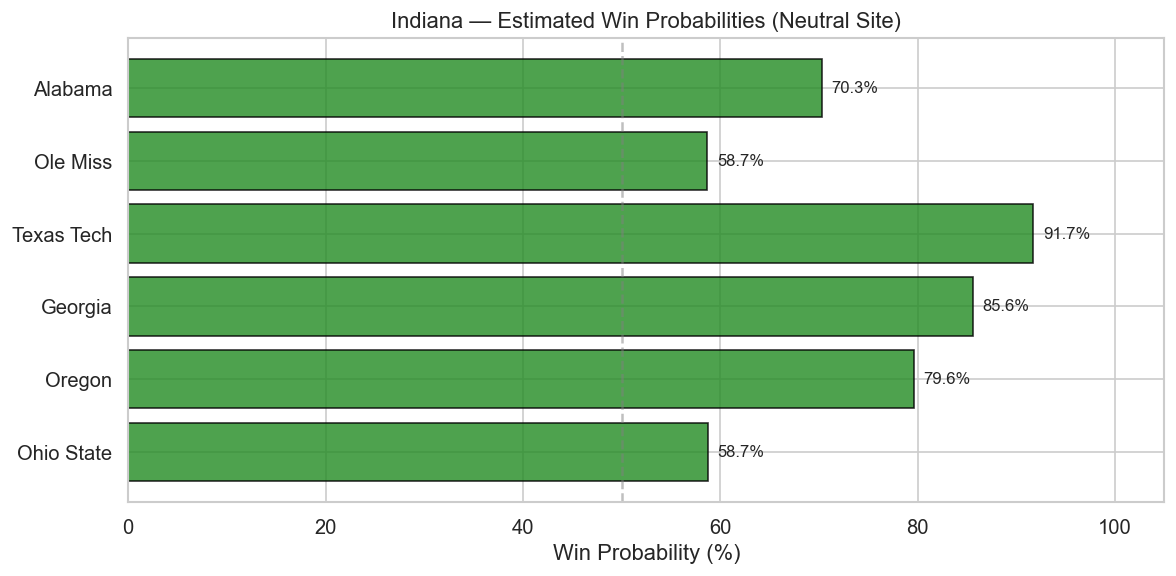

In [51]:
# Visualize win probabilities
fig, ax = plt.subplots(figsize=(10, 5))
colors = ["forestgreen" if p > 0.5 else "crimson" for p in schedule["Win_Prob"]]
bars = ax.barh(schedule["Opponent"], schedule["Win_Prob"] * 100, color=colors, edgecolor="black", alpha=0.8)
ax.axvline(50, ls="--", color="gray", alpha=0.5)
ax.set_xlabel("Win Probability (%)")
ax.set_title(f"{team} — Estimated Win Probabilities (Neutral Site)")

for bar, pct in zip(bars, schedule["Win_Prob_Pct"]):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            f"{pct}%", va="center", fontsize=10)

ax.set_xlim(0, 105)
plt.tight_layout()
plt.show()

### 7.1 Retrodict the Actual CFP Results

We can check how our win probability model would have predicted the actual 2025–26 CFP bracket results. Note that these are pre-tournament predictions based on regular season efficiency — not predictions made with knowledge of how teams played in the postseason.

In [52]:
# ══════════════════════════════════════════════════════════════
# Retrodict the actual 2025–26 CFP game results
# ══════════════════════════════════════════════════════════════

actual_games = [
    # First Round (at higher seed)
    ("Alabama", "Oklahoma", "Alabama", "First Round"),
    ("Miami (FL)", "Texas A&M", "Miami (FL)", "First Round"),
    ("Ole Miss", "Tulane", "Ole Miss", "First Round"),
    ("Oregon", "James Madison", "Oregon", "First Round"),
    # Quarterfinals (neutral site)
    ("Indiana", "Alabama", "Indiana", "Quarterfinal"),
    ("Ohio State", "Miami (FL)", "Miami (FL)", "Quarterfinal"),
    ("Georgia", "Ole Miss", "Ole Miss", "Quarterfinal"),
    ("Oregon", "Texas Tech", "Oregon", "Quarterfinal"),
    # Semifinals
    ("Indiana", "Oregon", "Indiana", "Semifinal"),
    ("Miami (FL)", "Ole Miss", "Miami (FL)", "Semifinal"),
    # Championship
    ("Indiana", "Miami (FL)", "Indiana", "Championship"),
]

game_results = []
for team_a, team_b, actual_winner, round_name in actual_games:
    try:
        wp = win_probability(team_a, team_b, hfa=0.0)  # neutral for all playoff games
        predicted_winner = team_a if wp > 0.5 else team_b
        correct = predicted_winner == actual_winner
        game_results.append({
            "Round": round_name,
            "Matchup": f"{team_a} vs {team_b}",
            "Predicted Winner": predicted_winner,
            "Pred. Win%": f"{max(wp, 1-wp)*100:.1f}%",
            "Actual Winner": actual_winner,
            "Correct?": "✅" if correct else "❌"
        })
    except IndexError:
        # Team name might not match dataset exactly
        game_results.append({
            "Round": round_name,
            "Matchup": f"{team_a} vs {team_b}",
            "Predicted Winner": "N/A",
            "Pred. Win%": "N/A",
            "Actual Winner": actual_winner,
            "Correct?": "⚠️ name mismatch"
        })

results_df = pd.DataFrame(game_results)
correct_count = sum(1 for r in game_results if r["Correct?"] == "✅")
total = sum(1 for r in game_results if r["Correct?"] in ["✅", "❌"])

print(f"Playoff prediction accuracy: {correct_count}/{total} games correct ({correct_count/total*100:.0f}%)\n")
results_df

Playoff prediction accuracy: 9/11 games correct (82%)



,Round,Matchup,Predicted Winner,Pred. Win%,Actual Winner,Correct?
0,First Round,Alabama vs Oklahoma,Alabama,87.7%,Alabama,✅
1,First Round,Miami (FL) vs Texas A&M,Miami (FL),81.1%,Miami (FL),✅
2,First Round,Ole Miss vs Tulane,Ole Miss,68.6%,Ole Miss,✅
3,First Round,Oregon vs James Madison,Oregon,51.3%,Oregon,✅
4,Quarterfinal,Indiana vs Alabama,Indiana,70.3%,Indiana,✅
5,Quarterfinal,Ohio State vs Miami (FL),Ohio State,55.6%,Miami (FL),❌
6,Quarterfinal,Georgia vs Ole Miss,Ole Miss,80.7%,Ole Miss,✅
7,Quarterfinal,Oregon vs Texas Tech,Oregon,73.9%,Oregon,✅
8,Semifinal,Indiana vs Oregon,Indiana,79.6%,Indiana,✅
9,Semifinal,Miami (FL) vs Ole Miss,Ole Miss,55.7%,Miami (FL),❌


## 8. Team Profile Tool

To make this analysis reusable, here's a function that generates a complete efficiency profile for any team in the dataset. This can be used as a scouting or comparison tool.

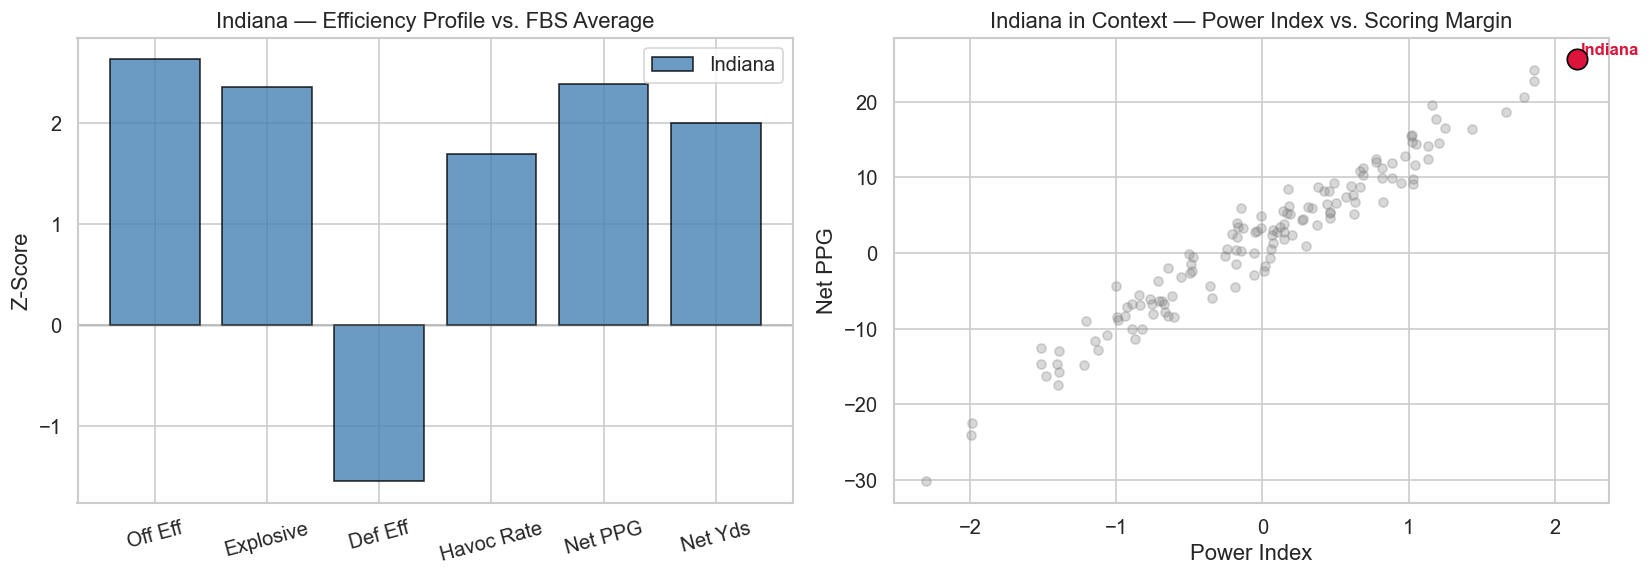


  Indiana  (Seed #1)
  Power Index: 2.151 (Rank #1)
  ✅ Made CFP


In [53]:
def team_profile(school_name):
    """Generate a visual efficiency profile for any FBS team."""
    team = df[df["School"] == school_name]
    if team.empty:
        print(f"Team '{school_name}' not found. Check spelling against df['School'].unique()")
        return

    row = team.iloc[0]
    team_z = team[z_cols].values.flatten()
    avg_z = np.zeros(len(metrics))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Bar chart: team vs average
    metric_labels = ["Off Eff", "Explosive", "Def Eff", "Havoc Rate", "Net PPG", "Net Yds"]
    x = np.arange(len(metrics))

    axes[0].bar(x, team_z, color="steelblue", edgecolor="black", alpha=0.8, label=school_name)
    axes[0].axhline(0, ls="-", color="gray", alpha=0.3)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metric_labels, rotation=15)
    axes[0].set_ylabel("Z-Score")
    axes[0].set_title(f"{school_name} — Efficiency Profile vs. FBS Average")
    axes[0].legend()

    # Context scatter
    axes[1].scatter(df["Power_Index"], df["Net_PPG"], alpha=0.3, color="gray", s=30)
    axes[1].scatter(row["Power_Index"], row["Net_PPG"],
                   color="crimson", s=150, zorder=5, edgecolors="black")
    axes[1].annotate(school_name, (row["Power_Index"] + 0.03, row["Net_PPG"] + 0.5),
                    fontsize=10, color="crimson", fontweight="bold")
    axes[1].set_xlabel("Power Index")
    axes[1].set_ylabel("Net PPG")
    axes[1].set_title(f"{school_name} in Context — Power Index vs. Scoring Margin")

    plt.tight_layout()
    plt.show()

    cfp_status = "✅ Made CFP" if row["Made_CFP"] else "❌ Did not make CFP"
    seed_str = f" (Seed #{cfp_seeds[school_name]})" if school_name in cfp_seeds else ""
    print(f"\n{'=' * 45}")
    print(f"  {school_name} {seed_str}")
    print(f"  Power Index: {row['Power_Index']:.3f} (Rank #{int(row['Power_Rank'])})")
    print(f"  {cfp_status}")
    print(f"{'=' * 45}")

# Example usage — try any team!
team_profile("Indiana")

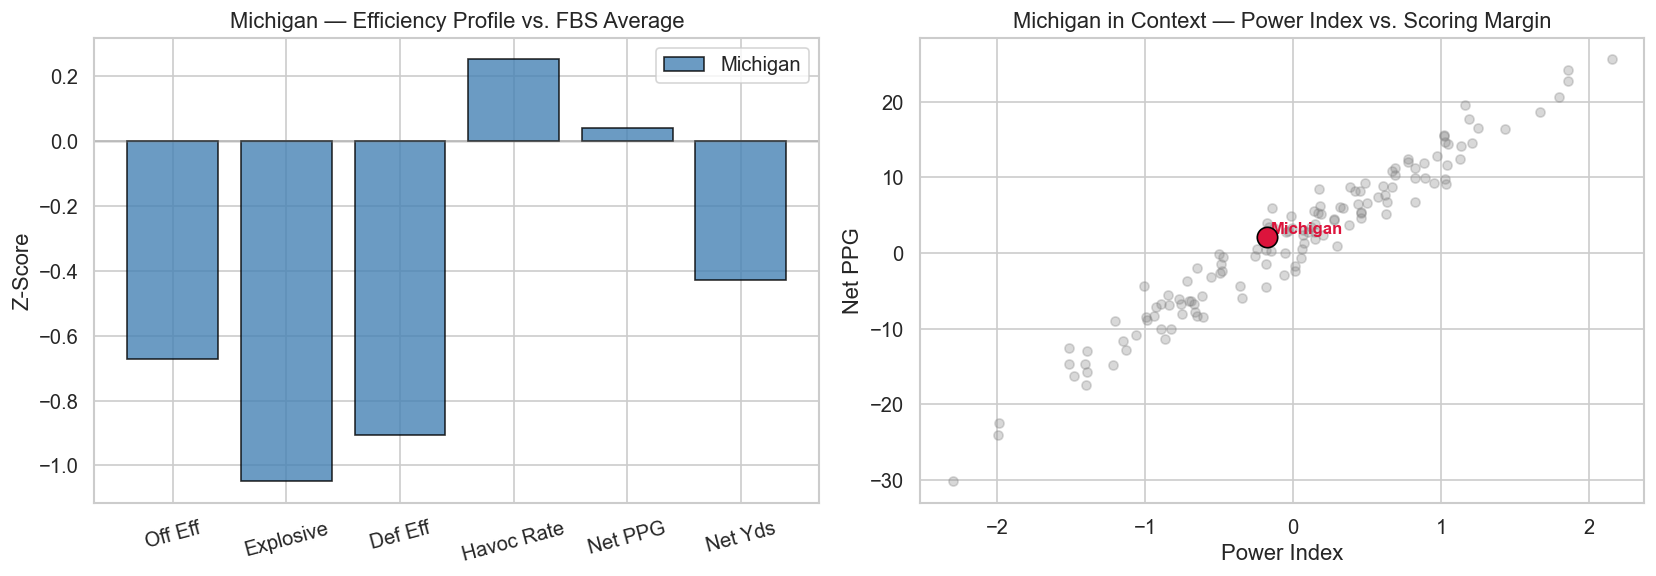


  Michigan 
  Power Index: -0.177 (Rank #82)
  ❌ Did not make CFP


In [ ]:
# Michigan
team_profile("Michigan")

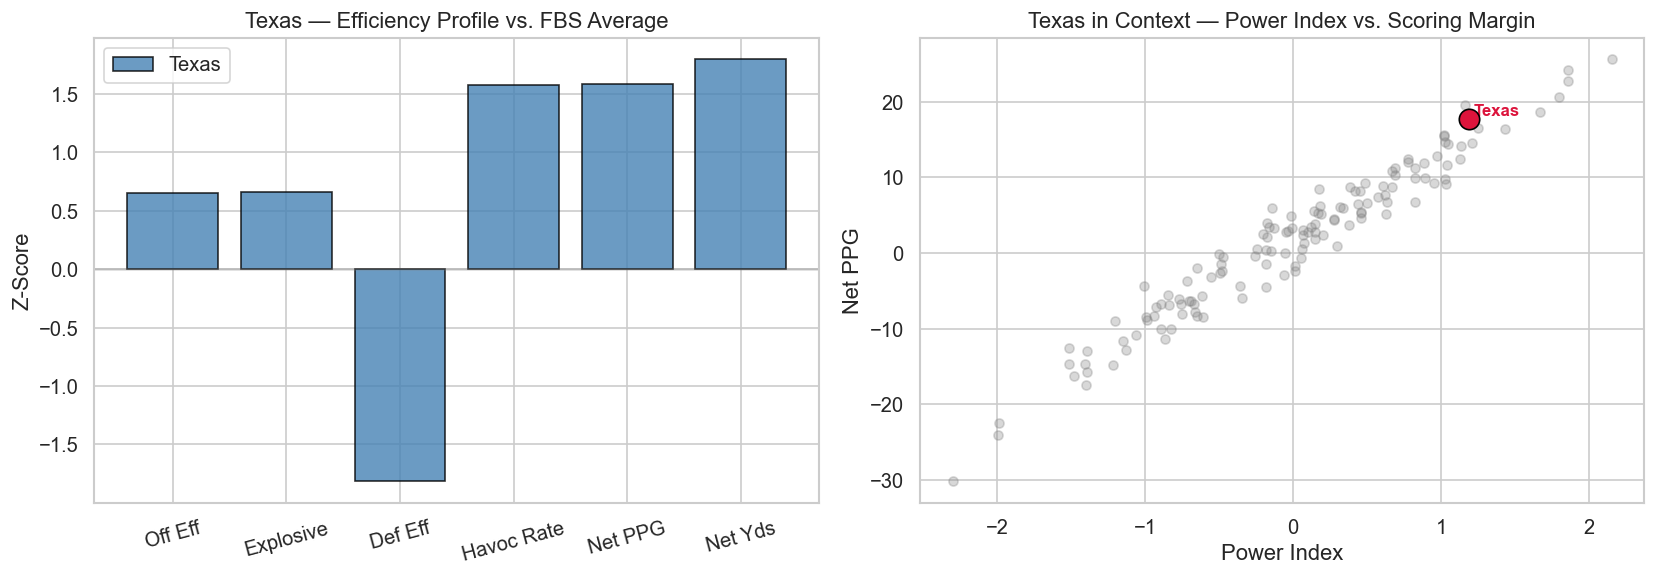


  Texas 
  Power Index: 1.190 (Rank #9)
  ❌ Did not make CFP


In [62]:
# Michigan
team_profile("Texas")

## 9. Limitations & Future Work

### Limitations

- **Weights are hand-tuned**, not optimized. A more rigorous approach would use logistic regression or gradient boosting to learn optimal weights from historical playoff outcomes across multiple seasons.
- **Single-season snapshot.** We cannot validate predictive power without out-of-sample testing across multiple years.
- **No strength-of-schedule adjustment.** A team's efficiency metrics are influenced by opponent quality, which this index does not account for. This especially affects Group of 5 teams (Tulane, James Madison) who may have inflated efficiency stats against weaker opponents.
- **Automatic bids change the game.** The CFP guarantees spots for the five highest-ranked conference champions, regardless of efficiency. Our index cannot predict *selection rules*, only *team quality*.

### Future Directions

- **Learn weights from data** — train a classifier on historical CFP/bowl outcomes to find optimal metric weights.
- **Add SOS (Strength of Schedule)** — weight metrics by opponent quality using conference-adjusted efficiency.
- **Multi-year validation** — test whether the 2024 index predicts 2025 outcomes and vice versa.
- **Expected Points Added (EPA)** — incorporate play-by-play EPA data for deeper efficiency measurement.
- **Clustering** — use unsupervised methods (K-Means, hierarchical) to identify team archetypes (e.g., "defensive grinders" vs. "offensive juggernauts").
- **Account for automatic bids** — build a two-stage model that first predicts conference champions, then ranks the remaining at-large field.

## 10. Conclusion

We constructed a composite Power Index from six efficiency metrics and evaluated its ability to identify the 2025–26 College Football Playoff field.

### Key Findings

**The efficiency-based Power Index captures CFP teams more accurately than raw offensive rankings.** By incorporating defensive metrics and per-play normalization, the index avoids the bias toward high-volume offenses that inflate raw point totals.

**The index correctly surfaces "complete" teams.** Programs that appear in our top rankings tend to be those with elite profiles on *both* sides of the ball, exactly the type of team that performs well in playoff environments. Indiana's championship run validates this as they combined offensive efficiency with defensive dominance.


**The win probability model provides a practical framework** for estimating head-to-head matchup outcomes, and its retroactive accuracy against actual CFP game results provides a useful (if imperfect) sanity check.

### The Bigger Picture

This project demonstrates how feature engineering and composite indexing can add analytical depth to college football evaluation, moving beyond "who scored the most" to "who is the most efficient on both sides of the ball." In a sport where subjective rankings drive billion-dollar decisions, data-driven alternatives deserve a seat at the table.

---
*Data sourced from publicly available 2025 FBS team statistics. Code and analysis available on [GitHub](your-repo-link).*